## Read STN and SST Data ##

In [2]:
# Req. library for revalue()
library(plyr)

# Get training data subject IDs
sst_train_fname <- '/home/dan/documents/lncc/synthetic data/sst_round_2/safe_train_data.csv'
sst_train_data  <- read.csv(file=sst_train_fname, header=TRUE, sep=',');

# Set directories for STN and stop signal data
stn_dir <- '/home/dan/documents/lncc/From Catherine/BL_STN_SSTtimeseries/'
sst_dir <- '/home/dan/documents/lncc/From Catherine/Round 2/SST/SST_BL_behavioraldata/'

# Set filename prefixes and suffixes
sst_pfx <- 'ss_'
stn_sfx <- 'STNboth_BL_SSTtimeseries'

# Specify ordinal coding for trial outcome
factor_key  <- c("GO_SUCCESS"="1", "GO_FAILURE"='2', 'STOP_SUCCESS'='3', 'STOP_FAILURE'='4',
                 'GO_TOO_LATE'='5','GO_WRONG_KEY_RESPONSE'='6', 'STOP_TOO_EARLY_RESPONSE'='7')

# Num. of subjects in training data
n_train     <- dim(sst_train_data['Subject'])[1]

# Init. arrays w/ conservative size estimates
stn_series  <- array(dim=c(444,n_train))
sst_times   <- array(dim=c(800,n_train))
sst_outcome <- array(dim=c(800,n_train))

# Loop through subjects and collect their data
for (subj_num in 1:n_train) {
    
    # File reading setup
    subj_id_num <- sst_train_data['Subject'][subj_num,]
    subj_id_str <- formatC(subj_id_num, width=12, format='d', flag='0')

    stn_fname <- paste(stn_dir, subj_id_str, '_', stn_sfx, sep='')
    sst_fname <- paste(sst_dir, sst_pfx, subj_id_str, '.csv', sep='')

    # Reading the STN Series
    cur_stn_series = tryCatch({
        # Only want to read one column, activations
        read.csv(file=stn_fname, header=TRUE, sep='\t', colClasses=c("NULL", "NULL", NA))
        }, error = function(e) { print(paste('Failure to read ', stn_fname)) }
    )
    
    # Reading the SST Series
    cur_sst_series = tryCatch({
        # Only want to read 2 columns, time and outcome
        cols <- c('NULL','NULL','numeric','NULL','NULL','NULL','NULL','NULL',
                  'NULL','NULL','NULL'   , NA   ,'NULL','NULL','NULL','numeric')
        read.csv(file=sst_fname, header=TRUE, sep='\t', colClasses=cols, skip=1)
        }, error = function(e) { print(paste('Failure to read ', sst_fname)) }
    )
    
    # Check if read call threw an error, if not extract the activations
    if(!is.character(cur_stn_series)){
        if (dim(cur_stn_series)[1]==444){
            stn_series[,subj_num] <- cur_stn_series$Mean_1
        }
    }

    # Check if read call threw an error, if not extract the trial times and outcomes
    if(!is.character(cur_sst_series)){
        if (!is.null(cur_sst_series)){
            len <- dim(cur_sst_series['Trial.Start.Time..Onset.'])[1]
            
            # Save the SST trial times
            sst_times[1:len, subj_num] <- cur_sst_series['Trial.Start.Time..Onset.'][,1]
            
            # Code outcome values
            cur_sst_series['Response.Outcome'][,1] <- revalue(cur_sst_series['Response.Outcome'][,1], factor_key, warn_missing=FALSE)
            sst_outcome[1:len, subj_num] <- as.numeric(as.character(cur_sst_series['Response.Outcome'][,1]))
        }
    }
}

# Standard deviatons - Was using this as a proxy for a little while. 
# stn_train <- data.frame('Subject' = sst_train_data['Subject'], 'stn_std' = apply(stn_series, 2, sd, na.rm = TRUE))

# Format the STN data as a dataframe and add TRs
stn_series <- data.frame(stn_series)
colnames(stn_series) <- paste('Subj_', 1:n_train, sep='');
stn_series['TR'] <- 1:444

# Mean shift and normalize STN data for each participant
for (feature in setdiff(colnames(stn_series), 'TR') ) {
    mean <- colMeans(stn_series[feature], na.rm=TRUE)
    stn_series[feature] <- (stn_series[feature] - mean) / mean *100
}

Warning message in read.table(file = file, header = header, sep = sep, quote = quote, :
“cols = 15 != length(data) = 16”Warning message in read.table(file = file, header = header, sep = sep, quote = quote, :
“cols = 15 != length(data) = 16”Warning message in read.table(file = file, header = header, sep = sep, quote = quote, :
“cols = 15 != length(data) = 16”Warning message in read.table(file = file, header = header, sep = sep, quote = quote, :
“cols = 15 != length(data) = 16”Warning message in read.table(file = file, header = header, sep = sep, quote = quote, :
“cols = 15 != length(data) = 16”

### Sanity Check: <br/> Inspect STN Activation and Outcomes ###

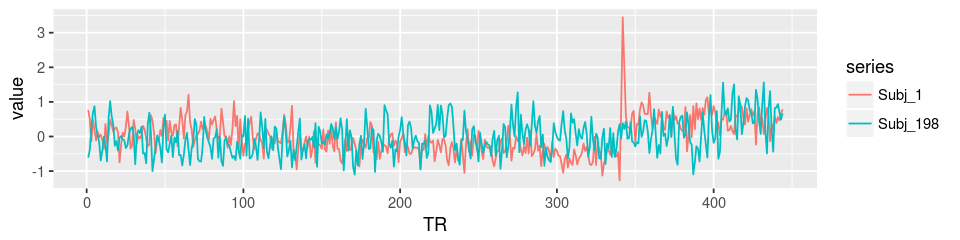

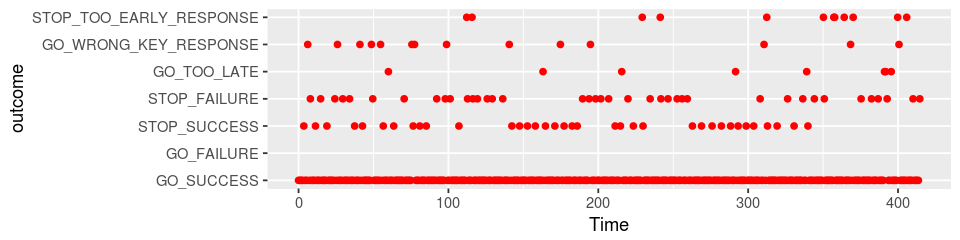

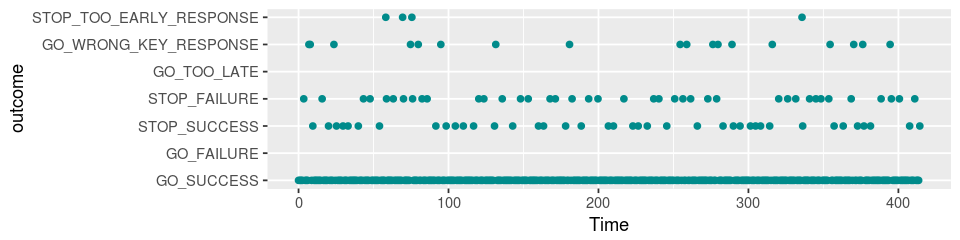

In [3]:
library(ggplot2)
library(reshape2)

options(repr.plot.width=8, repr.plot.height=2)
dmelt <- melt(stn_series[c('TR', 'Subj_1', 'Subj_198')], id.vars = 'TR', variable.name = 'series')
ggplot(dmelt, aes(TR, value)) + geom_line(aes(colour=series))

labels <- c("GO_SUCCESS", "GO_FAILURE", 'STOP_SUCCESS', 'STOP_FAILURE', 'GO_TOO_LATE', 'GO_WRONG_KEY_RESPONSE', 'STOP_TOO_EARLY_RESPONSE')

dmelt <- melt(data.frame('Outcome' = sst_outcome[,1], 'Time' = sst_times[,1]/1000/2.2), id.vars = 'Time', variable.name = 'series', na.rm=TRUE)
ggplot(dmelt, aes(Time, value)) + geom_point(colour='red') + scale_y_continuous('outcome', breaks=seq(1,7,1), labels=labels, c(1,7))

dmelt <- melt(data.frame('Outcome' = sst_outcome[,198], 'Time' = sst_times[,198]/1000/2.2), id.vars = 'Time', variable.name = 'series', na.rm=TRUE)
ggplot(dmelt, aes(Time, value)) + geom_point(colour='dark cyan') + scale_y_continuous('outcome', breaks=seq(1,7,1), labels=labels, c(1,7))

## Fit GLM to STN Activity ##

For each participant:
- Remove non-existent conditions from outcome set
- Determine onset times (in TRs)
- Set event durations (event-based --> 0s)
- Create expected activation timeseries via HRF - regressor convolution
- Create design matrix with second order polynomial drift
- Fit the model to the data

In [85]:
# fMRI analysis functions
library(fmri)

# Proportion of subjects w/ significant STN betas for STOP_SUCCESS
frac_go_sig   <- 0
frac_stop_sig <- 0

# Some book keeping...
n_to_fit <- 100
lm_list  <- vector("list", n_to_fit) 

# Loop through subjects
for (subj_num in 1:n_to_fit) {
    
    # Array for events convolved w/ HRF
    conv_regs <- array(dim = c(444, 7))
    
    # Some conditions do not occur - they will be removed
    bad_cond = c()
    
    # Fill the conv_regressors array for each condition
    for (cond in 1:7) {
        
        # Masks for getting trial times
        big_cond_msk <- apply(sst_outcome, c(1,2), function(x) x %in% cond)
        cond_msk     <- big_cond_msk[,subj_num]

        # If this condition doesn't occur, skip it.
        if (sum(cond_msk) == 0) {
            bad_cond <- cbind(bad_cond,cond)
            next
        }

        # For some reason fmri.stimulus can't handle the zero.
        # Only one of thousands of pts, so just 'fix' it.
        if (sst_times[cond_msk,subj_num][1] == 0) {
            sst_times[cond_msk,subj_num][1] <- 500
        }

        # Trial onset times and their durations - 0s for event design
        onsets    <- sst_times[cond_msk, subj_num]
        onsets    <- as.vector(na.omit(onsets/1000/2.2))
        durations <- double(length(onsets)) 
            
        # Get convolved regressor for condition
        conv_regs[,cond] <- fmri.stimulus(scans = 444, onsets = onsets, duration = durations)

    }
    # Create design matrix w/ 2nd deg drift, remove any bad conditions
    design_mat <- fmri.design(conv_regs[, setdiff(1:7, bad_cond)], order = 2)
    
    #print(design_mat)                          
    #design_mat <- design_mat[,setdiff(1:7, bad_cond)]
    #print(design_mat)

    # Clean up conv_regs a bit, append 'TR' column, label things
    conv_regs[,bad_cond] <- integer(444)
    conv_regs  <- data.frame(cbind(conv_regs, 1:444))
    colnames(conv_regs) <- c(labels,'TR')

    # Fit the linear model
    linear_model <- lm(stn_series[,1] ~ design_mat)

    # Save the linear model, list of conds removed, 
    lm_list[[subj_num]] <- list(lm=linear_model, bad_cond=bad_cond, conv_regs=conv_regs)

    # ------------------------- #
    # Actual processing is done #
    # ------------------------- #
    # Now stuff is just getting printed
    lm_desc <- summary(linear_model)
    coeff   <- lm_desc$coefficients
    
    # STOP_SUCCESS is coeff. 4 originally (cond 3)
    stop_ind <- 4
    if (2 %in% bad_cond) {
        stop_ind <- stop_ind - 1
    }

    # Information
    print(paste('Subject ', subj_num,
                ' GO_SUCCESS beta: ', round(coeff[2,'Estimate'], digits=2),
                '. Sig: ', coeff[2,'Pr(>|t|)'] < 0.05,
                ' STOP_SUCCESS beta: ', round(coeff[stop_ind,'Estimate'], digits=2),
                '. Sig: ', coeff[stop_ind,'Pr(>|t|)'] < 0.05, sep=''))
    
    if (coeff[2,'Pr(>|t|)'] < 0.05) {
        frac_go_sig <- frac_go_sig + 1
    }
    if (coeff[stop_ind,'Pr(>|t|)'] < 0.05) {
        frac_stop_sig <- frac_stop_sig + 1
    }
}

# Report on betas:
frac_go_sig   <- frac_go_sig  /n_to_fit
frac_stop_sig <- frac_stop_sig/n_to_fit

print('')
print(paste('Fraction of GO_SUCCESS   betas which are significant:', frac_go_sig))
print(paste('Fraction of STOP_SUCCESS betas which are significant:', frac_stop_sig))
                              
saveRDS(lm_list,'lm_list.rds')

[1] "Subject 1 GO_SUCCESS beta: -8.49. Sig: TRUE STOP_SUCCESS beta: -12.5. Sig: TRUE"
[1] "Subject 2 GO_SUCCESS beta: -7.54. Sig: TRUE STOP_SUCCESS beta: -11.14. Sig: TRUE"
[1] "Subject 3 GO_SUCCESS beta: -7.13. Sig: TRUE STOP_SUCCESS beta: -6.01. Sig: TRUE"
[1] "Subject 4 GO_SUCCESS beta: -9.33. Sig: TRUE STOP_SUCCESS beta: -12.64. Sig: TRUE"
[1] "Subject 5 GO_SUCCESS beta: -9.26. Sig: TRUE STOP_SUCCESS beta: -11.27. Sig: TRUE"
[1] "Subject 6 GO_SUCCESS beta: -7.24. Sig: TRUE STOP_SUCCESS beta: -7.16. Sig: TRUE"
[1] "Subject 7 GO_SUCCESS beta: -9.55. Sig: TRUE STOP_SUCCESS beta: -3.72. Sig: FALSE"
[1] "Subject 8 GO_SUCCESS beta: -7.85. Sig: TRUE STOP_SUCCESS beta: -8.86. Sig: TRUE"
[1] "Subject 9 GO_SUCCESS beta: -7.18. Sig: TRUE STOP_SUCCESS beta: -10.78. Sig: TRUE"
[1] "Subject 10 GO_SUCCESS beta: -8.7. Sig: TRUE STOP_SUCCESS beta: -8.85. Sig: TRUE"
[1] "Subject 11 GO_SUCCESS beta: -8.28. Sig: TRUE STOP_SUCCESS beta: -9.51. Sig: TRUE"
[1] "Subject 12 GO_SUCCESS beta: -8.21. Sig: TRU

## Sanity Check: <br/> Inspect Some Series with Significant Stop Betas ##

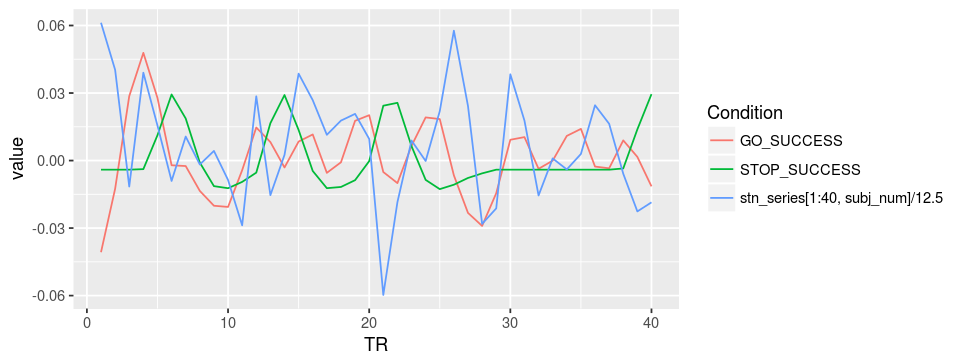

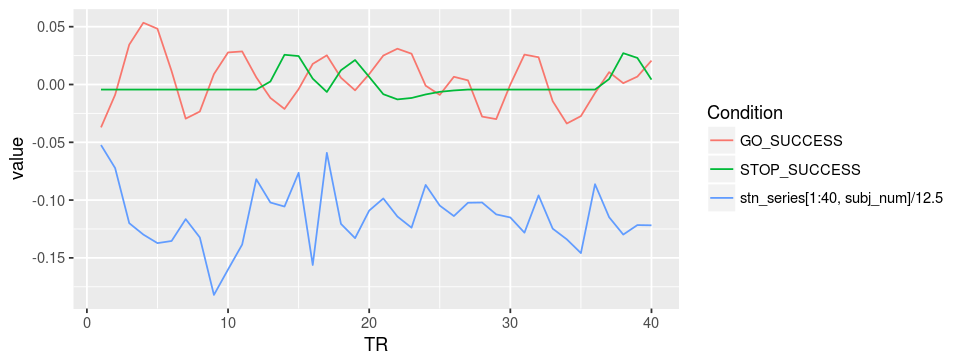

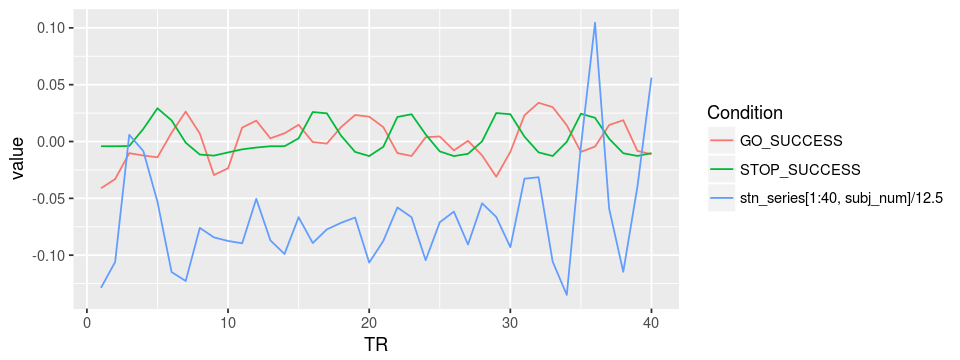

In [101]:
options(repr.plot.width=8, repr.plot.height=3)

nplts <- 3
for (subj_num in 1:nplts) {
    dmelt <- melt(cbind(lm_list[[subj_num]]$conv_regs[1:40,c(1,3,8)], stn_series[1:40,subj_num]/12.5), id.vars = 'TR', variable.name = 'Condition')
    plt <- ggplot(dmelt, aes(TR, value)) + geom_line(aes(colour=Condition))
    print(plt)
}

In [121]:
# Contrast go conds with stop conds ignoring 'failures'
# See 'labels' in cell one.
contr <- as.vector(c(-1, -1, 1, 1, -1, 0, 0, 0, 0, 0))
betas <- as.vector(lm_list[[1]]$lm$coefficients)
contr <- contr[setdiff(1:10,lm_list[[1]]$bad_cond)]
betas[is.na(betas)] <- 0

# Print betas and contrast vector
contr
betas

# Contrast result
contr %*% betas[2:10]

[1] -1  1  1 -1  0  0  0  0  0

[1]   0.5028017  -8.4892035 -12.5009729  -8.8263658   8.4514213 -10.1542028
 [7]   1.1031543   0.0000000  -1.7586648   1.2558631

-21.28956
